In [ ]:
"""
Check Generated Trajectories Notebook

This notebook provides utilities to:
1. Load and visualize generated trajectories
2. Analyze feature distributions and correlations
3. Evaluate model performance across different configurations
4. Generate human preference configurations
"""

import os
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import yaml
import itertools

from src.utils.parser import *

%load_ext autoreload
%autoreload 2

pybullet build time: Nov 28 2023 23:45:17


# Load Trajectories

Configure the trajectory path and load the dataset.

In [ ]:
# Configuration
traj_path = "../data/traj_sets/frankarobot_obj20_sg10_persg5.npy"  # Update this path as needed
env_config = "../config/envs/frankarobot.yaml"

# Load trajectories
traj_set = np.load(traj_path, allow_pickle=True)
print(f"Trajectory set loaded from {traj_path}")
print(f"Trajectory set shape: {traj_set.shape}")

# Load environment config
with open(env_config, "r") as stream:
    params = yaml.safe_load(stream)

# Set random seed
set_seed(12345)

# Make environment
env = make_env(params["env"])

# Split data
all_trajs, train_trajs, test_trajs = load_split_data(
    traj_path, 
    params["env"]["per_SG"], 
    params["env"]["train_test_split"]
)
print(f"Total: {len(all_trajs)}, Train: {len(train_trajs)}, Test: {len(test_trajs)}")

In [3]:
env_config = "../config/reward_learning/frankarobot.yaml"
with open(env_config, "r") as stream:
    params = yaml.safe_load(stream)

# Set random seed.
set_seed(12345)

# Make environment.
env = make_env(params["env"])

# Load data and split into train and test.
# all_trajs, train_trajs, test_trajs = load_split_data(params["env"]["trajset_file"], params["env"]["per_SG"], params["env"]["train_test_split"])
all_trajs, train_trajs, test_trajs = load_split_data(traj_path, params["env"]["per_SG"], params["env"]["train_test_split"])
print(len(all_trajs), len(test_trajs), len(train_trajs))

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
urdfdom: no axis element for Joint, defaulting to (1,0,0) axis chest
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
urdfdom: no axis element for Joint, defaulting to (1,0,0) axis neck
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
urdfdom: no axis element for Joint, defaulting to (1,0,0) axis right_hip
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
urdfdom: no axis element for Joint, defaulting to (1,0,0) axis right_ankle
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
urdfdom: no axis element for Joint, defaulting to (1,0,0) axis right_shoulder
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
urdfdom: no axis element for Joint, defaulting to (1,0,0) axis left_hip
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
urdfdom: no axis element for Joint, defaulting to (1,0

In [ ]:
# Configure human preferences for feature calculation
human_params = {
    "features": ["table", "laptop", "proxemics", "human", "coffee"],
    "feature_scaling": "normalize",
    "preferencer": {
        "theta": [1.0, 1.0, 1.0, 1.0, 1.0],
        "beta": 20.0,
        "f_method": "boltzmann",
        "s_method": "luce"
    },
    "type": params["env"]["type"]
}

# Create human and calculate features
human = make_human(human_params, env, train_trajs)
all_features = np.array([human.calc_features(traj) for traj in all_trajs])
print(f"Feature shape: {all_features.shape}")
print(f"Features: {human.features}")

In [5]:
# humans_config_path = "../config/humans/frankarobot.yaml"
# with open(humans_config_path, "r") as stream:
#     humans_params = yaml.safe_load(stream)
humans_params = [
    {
        "features": ["table", "laptop"], #, "proxemics", "human", "coffee"]
        "feature_scaling": "normalize",

        # Demonstration generation preferences for reward.
        "preferencer":
        {
        "theta": [ 1.0, 1.0 ],
        "beta": 20.0,
        "f_method": "boltzmann",
        "s_method": "luce"
        }
    },
    {
        "features": ["table", "laptop", "proxemics", "human", "coffee"], #]
        "feature_scaling": "normalize",

        # Demonstration generation preferences for reward.
        "preferencer":
        {
        "theta": [ 1.0, 1.0, 1.0, 1.0, 1.0],
        "beta": 20.0,
        "f_method": "boltzmann",
        "s_method": "luce"
        }
    }

]
human_params = humans_params[-1]
human_params["type"] = params["env"]["type"]
print(human_params)
# human = make_human(params["human"], env, train_trajs)
human = make_human(human_params, env, train_trajs)

# Generate human data.
# demos = human.generate_demos(args.demo_queries)
# train_features = np.array([human.calc_features(traj) for traj in train_trajs])
# demo_features = np.array([human.calc_features(traj) for traj in demos])
all_features = np.array([human.calc_features(traj) for traj in all_trajs])
print(all_features.shape)

{'features': ['table', 'laptop', 'proxemics', 'human', 'coffee'], 'feature_scaling': 'normalize', 'preferencer': {'theta': [1.0, 1.0, 1.0, 1.0, 1.0], 'beta': 20.0, 'f_method': 'boltzmann', 's_method': 'luce'}, 'type': 'frankarobot'}
human created in 0.8194003105163574
(1000, 5)


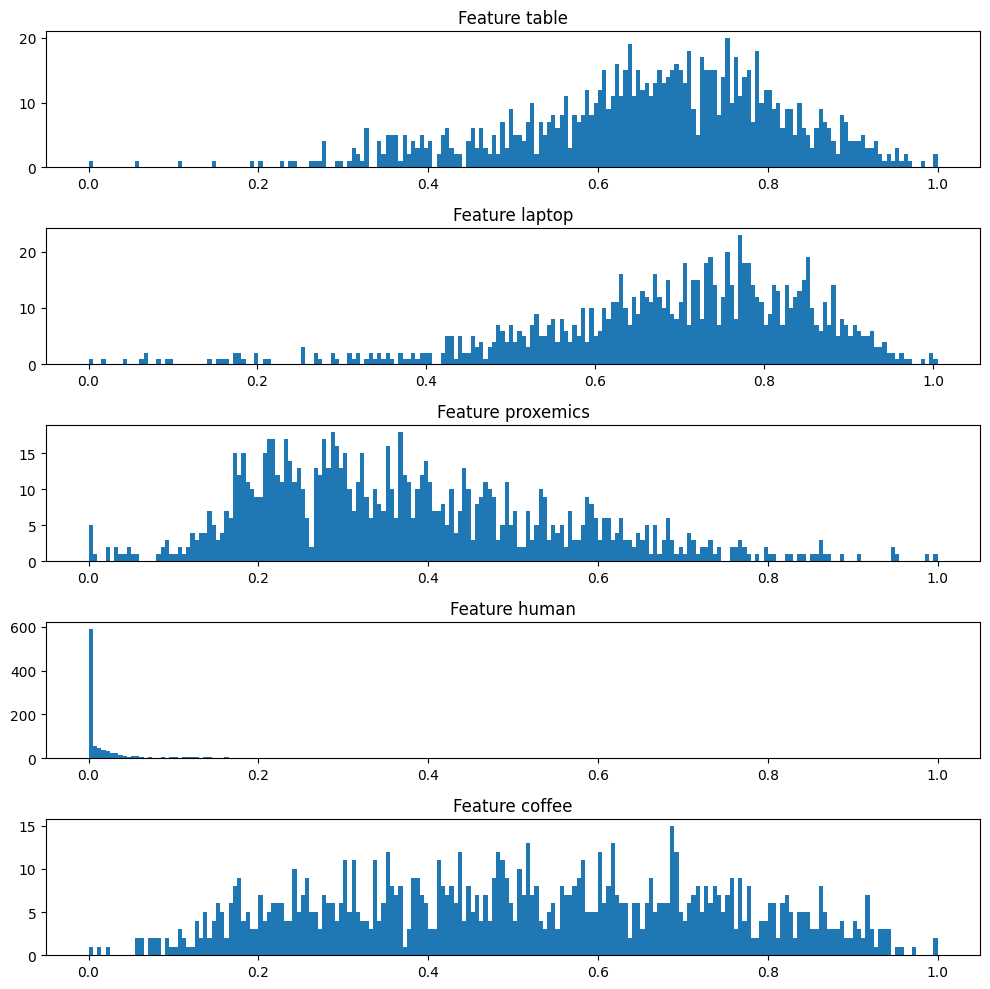

In [6]:
# plot histogram distribution of features for all trajectories
n_features = all_features.shape[1]
fig, axs = plt.subplots(n_features, 1, figsize=(10, 10))
for i in range(n_features):
    axs[i].hist(all_features[:, i], bins=200)
    axs[i].set_title("Feature {}".format(human.features[i]))

plt.tight_layout()
plt.show()

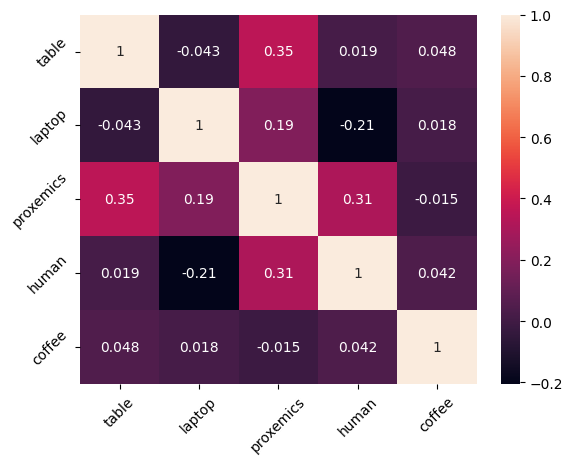

In [12]:
# plot a confusion matrix that shows the correlation between features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import seaborn as sns

# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(all_features)
# pca = PCA(n_components=2)

# features_pca = pca.fit_transform(features_scaled)
# print(features_pca.shape)

# # plot the PCA features
# # plt.scatter(features_pca[:, 0], features_pca[:, 1])
# # plot features with different colors for different classes
# plt.scatter(features_pca[:, 0], features_pca[:, 1], c=[0 for _ in range(len(all_trajs))])

# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.title("PCA of features")
# plt.show()

# plot the correlation matrix
corr = np.corrcoef(all_features.T)
sns.heatmap(corr, annot=True)
# set the x-axis labels and y-axis labels into the feature names, but shift them to the right and up a bit
plt.xticks(np.arange(n_features) + 0.5, human.features, rotation=45)
plt.yticks(np.arange(n_features) + 0.5, human.features, rotation=45)
plt.show()